In [319]:
import numpy as np
import pandas as pd
import matplotlib as plt
import pylab as pl
%pylab inline
import seaborn as sns

import statsmodels.formula.api as smf

from mpl_toolkits.mplot3d import Axes3D  # for 3D plot

from sklearn.mixture import GaussianMixture

import statsmodels.api as sm
import statsmodels.formula.api as smf
from numpy import linalg
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier

colors = ['y', 'm', 'c', 'r', 'g', 'b', 'k', 'DeepPink',\
          'DodgerBlue', 'Aquamarine', 'MediumSpringGreen',\
         'MidnightBlue', 'Gold', 'DarkSlateGray', 'LimeGreen', \
         'LightSeaGreen', 'Salmon', 'Indigo', 'DarkMagenta', \
         'Thistle', 'DeepSkyBlue', 'CadetBlue', \
         'BlueViolet', 'Chocolate', 'SaddleBrown', 'Maroon', \
         'Peru', 'DarkOrange', 'Teal', 'DarkKhaki']


Populating the interactive namespace from numpy and matplotlib


/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [79]:
schmelts = ['schmelt05-16.csv', 'schmelt09-16.csv', 'schmelt11-15.csv', 
            'schmelt13-16.csv', 'schmelt96-16.csv']

In [80]:
df = pd.read_csv('./schma_data/{}'.format(schmelts[0]))

In [81]:
df.LCGSCHCAT.value_counts(dropna=False)

ELEMENTARY              792
HIGH SCHOOL             549
JUNIOR HIGH-INTERMED    353
NaN                     112
K-12 ALL GRADES          41
SECONDARY SCHOOL         38
EARLY CHILDHOOD          37
COLLABORATIVE OR MUL     24
K-8                      24
DISTRICT PRE-K CENTE     13
UNGRADED                 12
CENTRAL-HQ-CITYWIDE       1
Name: LCGSCHCAT, dtype: int64

In [226]:
X = df.iloc[:, 1:-16]

In [343]:
list(df.columns)[-12:]

['RenewlSchl',
 'LCGSCHCAT',
 'LCGSCHTYP',
 'HSSCHSAMP2',
 'HSOPCTDRPTOT_cluster',
 'ENRNUMAFM_cluster',
 'ENRNUMHIS_cluster',
 'ENRNUMWHT_cluster',
 'ENRNUMSPD_cluster',
 'ENRPCTAFM_cluster',
 'ENRPCTHIS_cluster',
 'ENRPCTWHT_cluster']

In [346]:
y_cols = list(df.iloc[:, -8:].columns)
y_cols.append('RenewlSchl')

*** Filter out only elementary schools ***

In [254]:
elem = df[df.LCGSCHCAT == 'ELEMENTARY']

In [267]:
elem = elem.dropna(axis=0, how='all',subset=y_cols.columns)

In [268]:
elem.dropna(axis=0, how='all',subset=X.columns, inplace=True)

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [269]:
elem.dropna(axis=1, how='all', inplace=True)

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [271]:
drop_list = []
for col in elem.columns:
    if elem[col].isnull().sum() >= 100:
        drop_list.append(col)

In [272]:
len(drop_list)

99

In [273]:
elem.drop(drop_list, axis=1, inplace=True)

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [274]:
len(elem.columns)

393

In [277]:
(elem.isnull().sum(axis=1).sort_values(ascending=False)!=0).sum()

146

In [278]:
drop_row = []
for i in elem.index:
    if elem.isnull().sum(axis=1).loc[i] >= 90:
        drop_row.append(i)

In [279]:
len(drop_row)

4

In [280]:
len(elem.isnull().sum(axis=1))

631

In [281]:
elem.drop(drop_row, axis=0, inplace=True)

In [282]:
elem.isnull().sum().sort_values(ascending=False).head(20)

CLSAVGPRK mean05_16     95
CLSNUMPRK range05_16    95
ATTPCTPRK range05_16    95
CLSNUMPRK mean05_16     95
ATTPCTPRK mean05_16     95
CLSAVGPRK range05_16    95
ENRNUMSPD_cluster       31
CLSAVGOHS trend05_16    24
CLSAVGOHS std05_16      24
CLSNUMOHS std05_16      24
CLSNUMOHS trend05_16    24
CLSNUMOHS range05_16    17
CLSNUMOHS mean05_16     17
CLSAVGOHS range05_16    17
CLSAVGOHS mean05_16     17
CLSAVGG03 std05_16       5
ATTPCTG05 range05_16     5
ATTPCTG01 mean05_16      5
ATTPCTG05 std05_16       5
ATTPCTKID std05_16       5
dtype: int64

ATTPCTPRK - pre k -- fill w 0   - done
CLSAVGSPD - special ed -- fill w 0  -done
CLSNUMOHS - AVERAGE NUM OF STU PER CLASS: OTHER HIGH SCHOOLS (ENRNUM/CLSNUM) - drop for elem  - done

No values for the features below bc they don't have a 5th grade -- so no growth, or 5th grade ela proficiency
-- fill with value from 3rd gade proficiency and make growth == 0  
E_growth trend05_16   - filled w 0 - done           
E_growth std05_16                  - filled w 0 - done
ela5_decile trend05_16          - filled w. val for ela3 - done
ela5_decile std05_16   - filled w  vale for ela3 - done

fill with grade 3 value  
STCELAPCTL34G05 std05_16       
STCMTHPCTL34G05 std05_16         
STCELAPCTL34G05 trend05_16     
STCMTHPCTL34G05 trend05_16 


In [283]:
sub = 'PRK'
prk_cols = [s for s in elem.columns if sub in s]
print (prk_cols)
df[prk_cols] = df[prk_cols].fillna(value=0)

['ENRNUMPRK trend05_16', 'ATTPCTPRK mean05_16', 'CLSAVGPRK mean05_16', 'CLSNUMPRK mean05_16', 'ENRNUMPRK mean05_16', 'ENRNUMPRK std05_16', 'ATTPCTPRK range05_16', 'CLSAVGPRK range05_16', 'CLSNUMPRK range05_16', 'ENRNUMPRK range05_16']


In [284]:
sub = 'SPD'
SPD_cols = [s for s in elem.columns if sub in s]
print (SPD_cols)
df[SPD_cols] = df[SPD_cols].fillna(value=0)

['CLSAVGSPD trend05_16', 'CLSNUMSPD trend05_16', 'ENRNUMSPD trend05_16', 'CLSAVGSPD mean05_16', 'CLSNUMSPD mean05_16', 'ENRNUMSPD mean05_16', 'CLSAVGSPD std05_16', 'CLSNUMSPD std05_16', 'ENRNUMSPD std05_16', 'CLSAVGSPD range05_16', 'CLSNUMSPD range05_16', 'ENRNUMSPD range05_16', 'ENRNUMSPD_cluster']


In [285]:
sub = 'OHS'
OHS_cols = [s for s in elem.columns if sub in s]
print (OHS_cols)
elem.drop(OHS_cols, axis=1, inplace=True)

['CLSAVGOHS trend05_16', 'CLSNUMOHS trend05_16', 'ENRNUMOHS trend05_16', 'CLSAVGOHS mean05_16', 'CLSNUMOHS mean05_16', 'ENRNUMOHS mean05_16', 'CLSAVGOHS std05_16', 'CLSNUMOHS std05_16', 'ENRNUMOHS std05_16', 'CLSAVGOHS range05_16', 'CLSNUMOHS range05_16', 'ENRNUMOHS range05_16']


In [286]:
elem[['E_growth trend05_16','E_growth std05_16']] = elem[['E_growth trend05_16','E_growth std05_16']].fillna(0)

In [287]:
elem['ela5_decile trend05_16'] = elem['ela5_decile trend05_16'].fillna(elem['ela3_decile trend05_16'])
elem['ela5_decile std05_16'] = elem['ela5_decile std05_16'].fillna(elem['ela3_decile std05_16'])

In [288]:
for col in ['STCELAPCTL34G{} std05_16', 'STCMTHPCTL34G{} std05_16', 
            'STCELAPCTL34G{} trend05_16', 'STCMTHPCTL34G{} trend05_16']:
    elem[col.format('04')] = elem[col.format('04')].fillna(elem[col.format('03')])
    elem[col.format('05')] = elem[col.format('05')].fillna(elem[col.format('04')])

In [289]:
elem.isnull().sum().sort_values(ascending=False).head(20)

CLSNUMPRK mean05_16     95
ATTPCTPRK range05_16    95
CLSNUMPRK range05_16    95
ATTPCTPRK mean05_16     95
CLSAVGPRK mean05_16     95
CLSAVGPRK range05_16    95
ENRNUMSPD_cluster       31
CLSAVGG04 range05_16     5
CLSNUMKID std05_16       5
CLSNUMKID mean05_16      5
CLSNUMG03 std05_16       5
CLSNUMG04 std05_16       5
CLSAVGKID std05_16       5
CLSAVGG04 std05_16       5
ATTPCTKID std05_16       5
ATTPCTG05 std05_16       5
CLSNUMG04 mean05_16      5
CLSNUMG04 range05_16     5
CLSAVGKID mean05_16      5
CLSAVGG04 mean05_16      5
dtype: int64

All missing bc there isn't  a 4th or 5th grade class, so can fill in w 0

CLSNUMG04 std05_16  
CLSAVGG04 std05_16  
CLSAVGG04 trend05_16
CLSNUMG04 trend05_16
ATTPCTG05 trend05_16
ATTPCTG05 std05_16

enrollment values for dif demographics- can fill w 0
POV = poverty index
ELL = eng lang learners
OTH = other

ENRNUMPOV std05_16     
ENRNUMELL std05_16     
ENRNUMELL trend05_16  
ENRNUMELL mean05_16  
ENRNUMPOV range05_16  
ENRNUMOTH range05_16   
ENRNUMOTH std05_16     
ENRNUMOTH trend05_16 
ENRNUMPOV trend05_16 
ENRNUMELL range05_16
ENRNUMPOV mean05_16       
ENRNUMOTH mean05_16

In [290]:
cols_toz = ['CLSNUMG04 std05_16', 'CLSAVGG04 std05_16', 'CLSAVGG04 trend05_16',
            'CLSNUMG04 trend05_16', 'ATTPCTG05 trend05_16','ATTPCTG05 std05_16',
           'ENRNUMPOV std05_16','ENRNUMELL std05_16','ENRNUMELL trend05_16',
            'ENRNUMELL mean05_16','ENRNUMPOV range05_16','ENRNUMOTH range05_16',
            'ENRNUMOTH std05_16','ENRNUMOTH trend05_16','ENRNUMPOV trend05_16',
            'ENRNUMELL range05_16','ENRNUMPOV mean05_16','ENRNUMOTH mean05_16']

In [291]:
elem[cols_toz] = elem[cols_toz].fillna(0)

# Q: Should all this be feature engineered on the original SCHMA?

DMGPCTELLTOT - % ELL enrolled, impute to 0

growth vals - still na aftet imputing 3 g vals
-- set equal to 0? Or not enough information about the school? ie. not many grades to make a prediction on/to be relevant
ela3_decile std05_16          
ela5_decile std05_16          
ela5_decile trend05_16

In [211]:
elem[elem['ela3_decile std05_16'].isnull()][['STCELAPCTL34G03 mean05_16','STCELAPCTL34G03 std05_16' ,'ela3_decile std05_16']]

,STCELAPCTL34G03 mean05_16,STCELAPCTL34G03 std05_16,ela3_decile std05_16
161,31.800000,NaN,NaN
275,15.400000,NaN,NaN
285,NaN,NaN,NaN
674,35.600000,NaN,NaN
834,53.658540,NaN,NaN
937,NaN,NaN,NaN
940,40.909090,NaN,NaN
943,82.608700,NaN,NaN
1119,21.428570,NaN,NaN
1139,78.852549,22.976079,NaN


Why would a school have a vlaue for the mean, but not the std?

Fill in the rest of the Nans with 0z

In [292]:
elem = elem.fillna(0)

In [296]:
elem.columns

Index(['BNLONG', 'ATTPCTG01 trend05_16', 'ATTPCTG02 trend05_16',
       'ATTPCTG03 trend05_16', 'ATTPCTG04 trend05_16', 'ATTPCTG05 trend05_16',
       'ATTPCTKID trend05_16', 'ATTPCTTOT trend05_16', 'CBO trend05_16',
       'CLSAVGG01 trend05_16',
       ...
       'LCGSCHCAT', 'LCGSCHTYP', 'HSSCHSAMP2', 'ENRNUMAFM_cluster',
       'ENRNUMHIS_cluster', 'ENRNUMWHT_cluster', 'ENRNUMSPD_cluster',
       'ENRPCTAFM_cluster', 'ENRPCTHIS_cluster', 'ENRPCTWHT_cluster'],
      dtype='object', length=381)

In [303]:
elem.iloc[:, 1:-14]

,ATTPCTG01 trend05_16,ATTPCTG02 trend05_16,ATTPCTG03 trend05_16,ATTPCTG04 trend05_16,ATTPCTG05 trend05_16,ATTPCTKID trend05_16,ATTPCTTOT trend05_16,CBO trend05_16,CLSAVGG01 trend05_16,CLSAVGG02 trend05_16,...,STCELAPCTL34G03 range05_16,STCELAPCTL34G04 range05_16,STCELAPCTL34G05 range05_16,STCELAPCTL34TOT range05_16,STCMTHPCTL34G03 range05_16,STCMTHPCTL34G04 range05_16,STCMTHPCTL34G05 range05_16,STCMTHPCTL34TOT range05_16,ela3_decile range05_16,ela5_decile range05_16
0,0.220909,0.189091,0.204545,0.250909,0.177273,0.191818,0.242727,0.0,0.200866,0.694805,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
2,0.290909,0.019091,0.089091,0.065455,0.181818,-0.069091,0.052727,0.0,0.672727,0.018182,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
4,0.610000,0.410000,0.164545,0.283636,0.459091,0.234545,0.297273,0.0,-0.209091,0.151515,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
5,0.308182,0.107273,0.088182,-0.088182,0.156364,0.600000,0.140000,0.0,0.496753,0.854545,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
6,0.174545,0.102727,0.097273,0.062727,0.400000,0.069091,0.150000,0.0,0.200957,0.738756,...,12.0,12.0,4.0,12.0,12.0,12.0,4.0,12.0,12.0,4.0
7,0.422727,0.230000,0.424545,0.217273,0.700909,0.303636,0.392727,0.0,0.313131,-1.717172,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
8,0.678182,0.490000,0.349091,0.314545,0.294545,0.645455,0.513636,0.0,0.681818,1.220779,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
9,0.300000,0.228182,0.444545,0.310000,0.281818,0.482727,0.337273,0.0,2.090909,1.668182,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
10,0.567273,0.274545,0.526364,0.233636,0.490000,0.964545,0.486364,0.0,1.284848,1.141414,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
11,0.507273,0.373636,0.217273,0.524545,0.451818,0.568182,0.412727,0.0,1.878788,-0.333333,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0


In [313]:
X = elem.iloc[:, 1:-14]

In [325]:
y_cols.columns[1:]

Index(['ENRNUMAFM_cluster', 'ENRNUMHIS_cluster', 'ENRNUMWHT_cluster',
       'ENRNUMSPD_cluster', 'ENRPCTAFM_cluster', 'ENRPCTHIS_cluster',
       'ENRPCTWHT_cluster'],
      dtype='object')

In [329]:
def tree_fits(X, y):
    #split training and test data (Set before the missing dates, and after the missing dates)
    X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=999)
    
   
    # learn model
    dt=DecisionTreeClassifier()
    dt.fit(X_train,y_train)
    
    print ('Decision Tree Classifier Results: ')
    # in sample accuracy
    print ('In sample accuracy:',dt.score(X_train,y_train))

    # out of sample accuracy
    print ('Out of sample accuracy:',dt.score(X_test,y_test))

    print ('\n')
    # learn model
    dt=RandomForestClassifier()
    dt.fit(X_train,y_train)

    # in sample accuracy
    print ('Random Forest Classifier Results: ')
    print ('In sample accuracy:',dt.score(X_train,y_train))

    # out of sample accuracy
    print ('Out of sample accuracy:',dt.score(X_test,y_test))
    
    print ('\n')
    
    # learn model
    dt=ExtraTreeClassifier()
    dt.fit(X_train,y_train)

    print ('Extra Tree Classifier Results: ')
    # in sample accuracy
    print ('In sample accuracy:',dt.score(X_train,y_train))

    # out of sample accuracy
    print ('Out of sample accuracy:',dt.score(X_test,y_test))
    print ('\n')
    

In [350]:
for y_col in y_cols[1:]:
    y = elem[y_col]
    print ('Elementary, {} Decision Tree Results (no tuning): '.format(y_col))
    tree_fits(X, y)

Elementary, ENRNUMAFM_cluster Decision Tree Results (no tuning): 
Decision Tree Classifier Results: 
In sample accuracy: 1.0
Out of sample accuracy: 0.375661375661


Random Forest Classifier Results: 
In sample accuracy: 0.981735159817
Out of sample accuracy: 0.492063492063


Extra Tree Classifier Results: 
In sample accuracy: 1.0
Out of sample accuracy: 0.402116402116


Elementary, ENRNUMHIS_cluster Decision Tree Results (no tuning): 
Decision Tree Classifier Results: 
In sample accuracy: 1.0
Out of sample accuracy: 0.497354497354


Random Forest Classifier Results: 
In sample accuracy: 0.990867579909
Out of sample accuracy: 0.481481481481


Extra Tree Classifier Results: 
In sample accuracy: 1.0
Out of sample accuracy: 0.333333333333


Elementary, ENRNUMWHT_cluster Decision Tree Results (no tuning): 
Decision Tree Classifier Results: 
In sample accuracy: 1.0
Out of sample accuracy: 0.507936507937


Random Forest Classifier Results: 
In sample accuracy: 0.997716894977
Out of sample ac

In [353]:
y = elem['ENRNUMAFM_cluster']

In [332]:
y = elem['ENRNUMAFM_cluster']

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=999)

param_grid ={'n_estimators':np.arange(1,52,3),
            'min_samples_leaf':np.arange(1,50,5)} 

dt=RandomForestClassifier()#don't specifcy alpha in the intialization
gr=GridSearchCV(dt,param_grid=param_grid)#pass in predictor, and gridded parameters
rs=gr.fit(X_train,y_train)#run predictor with each parameter using training data
print (rs.best_params_)

{'min_samples_leaf': 1, 'n_estimators': 31}


In [337]:
(rs.predict(X_test) == y_test).sum() / len(y_test)

0.52380952380952384

In [354]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = i)

#from sklearn.model_selection import GridSearchCV 
param_grid ={'max_depth':np.arange(1,20,2),
            'max_leaf_nodes':np.arange(2,20,2)} #choose a grid of parameters

OS=[]
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = i)
    dt=RandomForestClassifier()#don't specifcy alpha in the intialization
    gr=GridSearchCV(dt,param_grid=param_grid)#pass in predictor, and gridded parameters
    rs=gr.fit(X_train,y_train)#run predictor with each parameter using training data
    print (rs.best_params_) #will output the best parameter, the best alpha
    OS.append((rs.predict(X_test) == y_test).sum() / len(y_test))
print (np.mean(OS))

{'max_depth': 3, 'max_leaf_nodes': 14}
{'max_depth': 5, 'max_leaf_nodes': 6}
{'max_depth': 3, 'max_leaf_nodes': 6}
{'max_depth': 19, 'max_leaf_nodes': 12}
{'max_depth': 5, 'max_leaf_nodes': 10}
{'max_depth': 11, 'max_leaf_nodes': 12}
{'max_depth': 11, 'max_leaf_nodes': 8}
{'max_depth': 9, 'max_leaf_nodes': 10}
{'max_depth': 9, 'max_leaf_nodes': 10}
{'max_depth': 13, 'max_leaf_nodes': 12}
0.523505976096


In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = i)

#from sklearn.model_selection import GridSearchCV 
param_grid ={'n_estimators':np.arange(1,52,3),
            'min_samples_leaf':np.arange(1,50,5)} #choose a grid of parameters

OS=[]
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = i)
    dt=RandomForestClassifier(max_depth=10, max_leaf_nodes=10)#don't specifcy alpha in the intialization
    gr=GridSearchCV(dt,param_grid=param_grid)#pass in predictor, and gridded parameters
    rs=gr.fit(X_train,y_train)#run predictor with each parameter using training data
    print (rs.best_params_) #will output the best parameter, the best alpha
    OS.append((rs.predict(X_test) == y_test).sum() / len(y_test))
print (np.mean(OS))

{'min_samples_leaf': 1, 'n_estimators': 28}


In [ ]:
n_est = np.arange(1,100,3)
OS_ = []
for i in n_est:
    rf = RandomForestClassifier(n_estimators=i, n_jobs=-1,min_samples_leaf=1)
    rf.fit(X_train, y_train)
    pred=rf.predict(X_test)
    #OS_AUC.append(roc_auc_score(y_test,pred)) #my solution
    OS_.append((rs.predict(X_test) == y_test).sum() / len(y_test))
    
plt.figure(figsize=(7,5))
plt.plot(n_est,OS_)
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Estimators")
#plt.xlim(2,500)
plt.show()

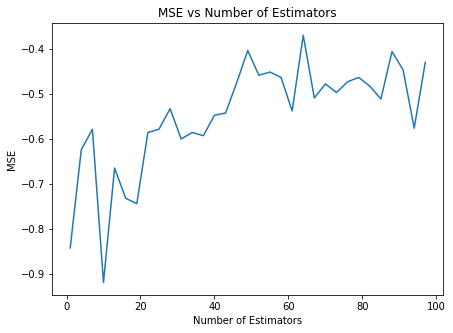

In [348]:
n_est = np.arange(1,100,3)
OS_ = []
for i in n_est:
    rf = RandomForestClassifier(n_estimators=i, n_jobs=-1,min_samples_leaf=1)
    rf.fit(X_train, y_train)
    pred=rf.predict(X_test)
    #OS_AUC.append(roc_auc_score(y_test,pred)) #my solution
    OS_.append((rs.predict(X_test) == y_test).sum() / len(y_test))
    
plt.figure(figsize=(7,5))
plt.plot(n_est,OS_)
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Estimators")
#plt.xlim(2,500)
plt.show()